In [42]:
%matplotlib inline
import keras
import keras.backend     as K
import matplotlib.pyplot as plt
import numpy             as np

from keras.models         import Sequential
from keras.layers         import Convolution2D
from keras.layers         import AveragePooling2D
from keras.layers         import Activation
from keras.layers         import Dense
from keras.layers         import Flatten
from keras.layers         import Reshape
from keras.layers         import UpSampling2D
from keras.optimizers     import Adam
from keras.utils.np_utils import to_categorical
from keras.datasets       import mnist

path_to_fashion_mnist = '../../datasets/fashion-mnist/'

import sys
sys.path.insert(0, path_to_fashion_mnist)
from utils import mnist_reader

In [2]:
anomalies_number = 400
encoding_size    = 100
batch_size       = 64

# Dataset creation

## Dataset loading

First, we load the fashion MNIST dataset.

In [3]:
X_train_fashion, _ = mnist_reader.load_mnist(path_to_fashion_mnist + 'data/fashion', kind = 'train')
X_test_fashion, _  = mnist_reader.load_mnist(path_to_fashion_mnist + 'data/fashion', kind = 't10k')
X_fashion          = np.concatenate((X_train_fashion, X_test_fashion)).reshape(-1, 28, 28, 1)

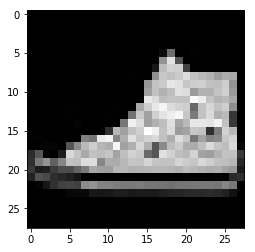

In [4]:
plt.imshow(X_fashion[35].squeeze(), cmap = 'gray')

Then we load the digit MNIST dataset.

In [5]:
(X_train_digits, _), (X_test_digits, _) = mnist.load_data()
X_digits                                = np.concatenate((X_train_digits, X_test_digits)).reshape(-1, 28, 28, 1)

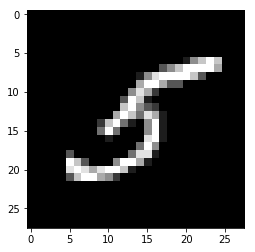

In [6]:
plt.imshow(X_digits[35].squeeze(), cmap = 'gray')

## Anomaly dataset creation creation

Now, we extract `anomaly_number` images from the fashion MNIST dataset. Then, we create a big dataset with all the MNIST digits and these `anomaly number` images.

In [7]:
anomalies = np.random.permutation(X_fashion)[:400]

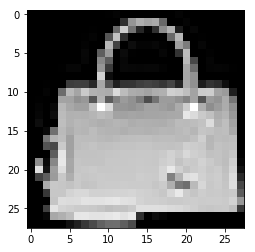

In [8]:
plt.imshow(anomalies[39].squeeze(), cmap = 'gray')

In [9]:
X = np.concatenate((X_digits, anomalies))
X = np.random.permutation(X)
X = (X - X.mean()) / X.std()

# Replicator network

The intuition that I have on replicator network is that they are autoencoders (a highly specialized compressor and decompressor) trained on the whole dataset. The idea is that the "usual" will be handled quite well by our autoencoder in the sense that the structure of the data will be well understood, i.e. the image produced by encoding and then decoding will be very close to the original one. To discover anomalies in our dataset, we will try to look for images that differ a lot from their compressed and decompressed counterparts.

Let's first build and train this autoencoder.

In [10]:
encoder = Sequential([
    Convolution2D(64, (3, 3), padding = 'same', input_shape = (28, 28, 1), activation = 'relu'),
    Convolution2D(64, (3, 3), padding = 'same', activation = 'relu'),
    AveragePooling2D(),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(encoding_size),
])

In [11]:
decoder = Sequential([
    Dense(49, input_shape = (encoding_size,), activation = 'relu'),
    Reshape((7, 7, 1)),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    UpSampling2D(),
    Convolution2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Convolution2D(64, (3, 3), padding = 'same', activation = 'relu'),
    UpSampling2D(),
    Convolution2D(1, (3, 3), padding = 'same', activation = 'tanh')
])

In [12]:
autoencoder = Sequential([
    encoder,
    decoder
])
autoencoder.compile(optimizer = Adam(1e-4), loss = 'mse')

In [13]:
fit_params = {
    'x'               : X,
    'y'               : X,
    'batch_size'      : batch_size,
    'epochs'          : 5,
    'validation_split': 0.15
}

In [14]:
autoencoder.fit(**fit_params)

Train on 59840 samples, validate on 10560 samples
Epoch 1/5
59840/59840 [==============================] - 129s - loss: 0.4075 - val_loss: 0.3555
Epoch 2/5
59840/59840 [==============================] - 132s - loss: 0.3482 - val_loss: 0.3452
Epoch 3/5
59840/59840 [==============================] - 130s - loss: 0.3407 - val_loss: 0.3407
Epoch 4/5
59840/59840 [==============================] - 138s - loss: 0.3373 - val_loss: 0.3378
Epoch 5/5
59840/59840 [==============================] - 132s - loss: 0.3353 - val_loss: 0.3360


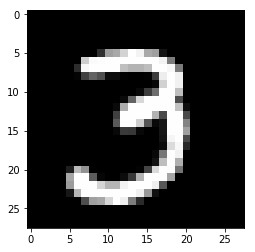

In [15]:
img = X[22]
plt.imshow(img.squeeze(), cmap = 'gray')

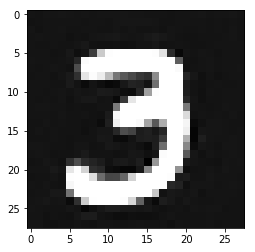

In [17]:
img_ = autoencoder.predict(np.expand_dims(img, 0))
plt.imshow(img_.squeeze(), cmap = 'gray')

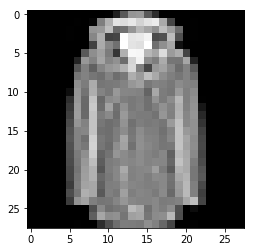

In [20]:
fashion_img = np.expand_dims(X_fashion[22], 0)
plt.imshow(fashion_img[0].squeeze(), cmap = 'gray')

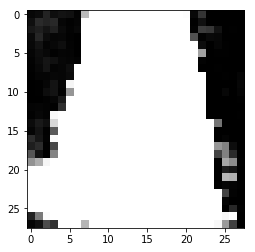

In [23]:
fashion_img_ = autoencoder.predict(fashion_img)
plt.imshow(fashion_img_[0].squeeze(), cmap = 'gray')

In [24]:
# autoencoder.save_weights('../models/autoencoder_%dD.h5')

In [25]:
autoencoder.load_weights('../models/autoencoder_%dD.h5')

In [26]:
X_ = autoencoder.predict(X, batch_size = 128)

In [51]:
pixel_mse = ((X - X_) ** 2).squeeze()
image_mse = pixel_mse.reshape(pixel_mse.shape[0], -1).mean(axis = 1)

(array([  2.86000000e+02,   2.14900000e+03,   5.38100000e+03,
          8.43000000e+03,   1.01840000e+04,   1.05460000e+04,
          9.57100000e+03,   7.68100000e+03,   5.68900000e+03,
          4.09400000e+03,   2.59200000e+03,   1.57100000e+03,
          9.67000000e+02,   5.39000000e+02,   3.12000000e+02,
          1.82000000e+02,   8.80000000e+01,   5.00000000e+01,
          3.00000000e+01,   1.70000000e+01,   1.10000000e+01,
          7.00000000e+00,   4.00000000e+00,   5.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   3.00000000e+00]),
 array([ 0.04080527,  0.08839462,  0.13598398,  0.18357334,  0.23116269,
         0.27875205,  0.3263414 ,  0.37393076,  0.42152012,  0.46910947,
         0.51669883,  0.56428818,  0.61187754,  0.6594669 ,  0.70705625,
         0.75464561,  0.80223496,  0.84982432,  0.89741368,  0.94500303,
         0.99259239,  1.04018174,  1.0877711 ,  1.13536046,  1.18294981,
         1.23

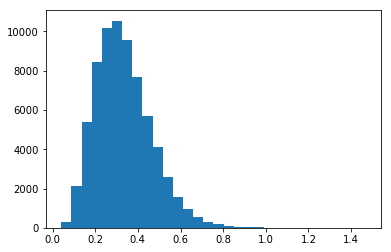

In [56]:
plt.hist(image_mse, bins = 30)

In [57]:
reconstruction_loss_sort_idx = image_mse.argsort()

In [64]:
def create_visualization(X, n, loss_idx):
    plt.figure(figsize = (15, 15))
    X_high_loss = X[loss_idx[-n**2:]]
    for i in range(n):
        for j in range(n):
            idx = i * n + j
            plt.subplot(n, n, idx + 1)
            img = X_high_loss[idx].squeeze()
            plt.imshow(img, cmap = 'gray')
            plt.axis('off')

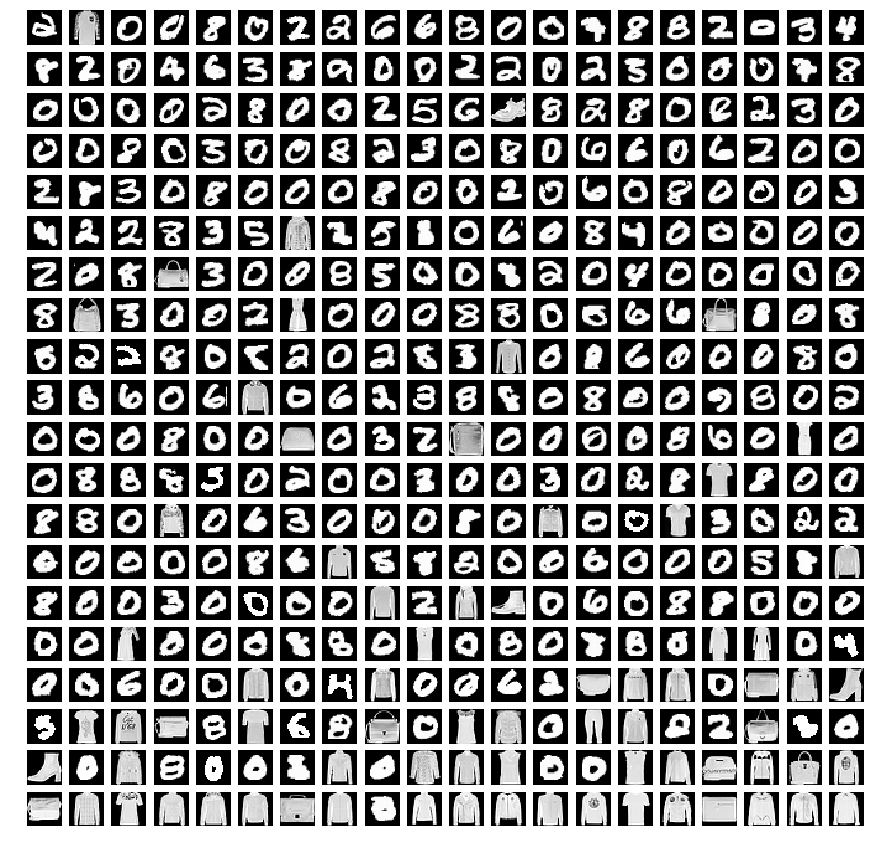

In [67]:
create_visualization(X, 20, reconstruction_loss_sort_idx)